# Explore Data In Redshift

In [1]:
# Install SQL Alchemy
!pip install -q SQLAlchemy==1.3.13

### Set Redshift Connection Parameters

In [2]:
redshift_schema = 'redshift'
redshift_cluster_identifier = 'dsoaws'
redshift_host = 'dsoaws'
redshift_database = 'dsoaws'
redshift_port = '5439'
redshift_table_2015 = 'amazon_reviews_tsv_2015'
redshift_table_2014 = 'amazon_reviews_tsv_2014'

### Load the Redshift Secrets from Secrets Manager

In [3]:
import json
import boto3

secretsmanager = boto3.client('secretsmanager')

secret = secretsmanager.get_secret_value(SecretId='dsoaws_redshift_login')
cred = json.loads(secret['SecretString'])

redshift_username = cred[0]['username']
redshift_pw = cred[1]['password']

In [4]:
redshift = boto3.client('redshift')
response = redshift.describe_clusters(ClusterIdentifier=redshift_cluster_identifier)
redshift_endpoint_address = response['Clusters'][0]['Endpoint']['Address']

print(redshift_endpoint_address)

dsoaws.cmibhdtvl5bj.us-west-2.redshift.amazonaws.com


### Create the Redshift Query Engine 

In [5]:
from sqlalchemy import create_engine
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(redshift_username, redshift_pw, redshift_endpoint_address, redshift_port, redshift_database))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### Prepare For Visualizations

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


### Set Seaborn parameters in advance

In [7]:
sns.set_style = 'seaborn-whitegrid'

sns.set(rc={"font.style":"normal",
            "axes.facecolor":"white",
            'grid.color': '.8',
            'grid.linestyle': '-',
            "figure.facecolor":"white",
            "figure.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':10,
            'figure.figsize':(10.0, 10.0),
            'xtick.labelsize':10,
            'font.size':10,
            'ytick.labelsize':10})

### Custom code to display values on bars

In [8]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()),2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

## 1. Which product categories had the most reviews in 2015?

In [9]:
statement = """
SELECT
    year,
    product_category,
    COUNT(star_rating) AS count_star_rating   
FROM
    {}.{}  
GROUP BY
    product_category,
    year  
ORDER BY
    count_star_rating DESC,
    year DESC
""".format(redshift_schema, redshift_table_2015)

print(statement)


SELECT
    year,
    product_category,
    COUNT(star_rating) AS count_star_rating   
FROM
    redshift.amazon_reviews_tsv_2015  
GROUP BY
    product_category,
    year  
ORDER BY
    count_star_rating DESC,
    year DESC



In [10]:
df = pd.read_sql_query(statement, engine)

In [11]:
df

,year,product_category,count_star_rating
0,2015,Digital_Software,35585
1,2015,Digital_Video_Games,30026


In [12]:
# Store counts
count_ratings = df['count_star_rating']

# Store number of categories
num_categories = df['product_category'].count()
print(num_categories)

# Store max ratings
max_ratings = df['count_star_rating'].max()
print(max_ratings)

# Store min ratings
min_ratings = df['count_star_rating'].min()
print(min_ratings)

2
35585
30026


## Visualization

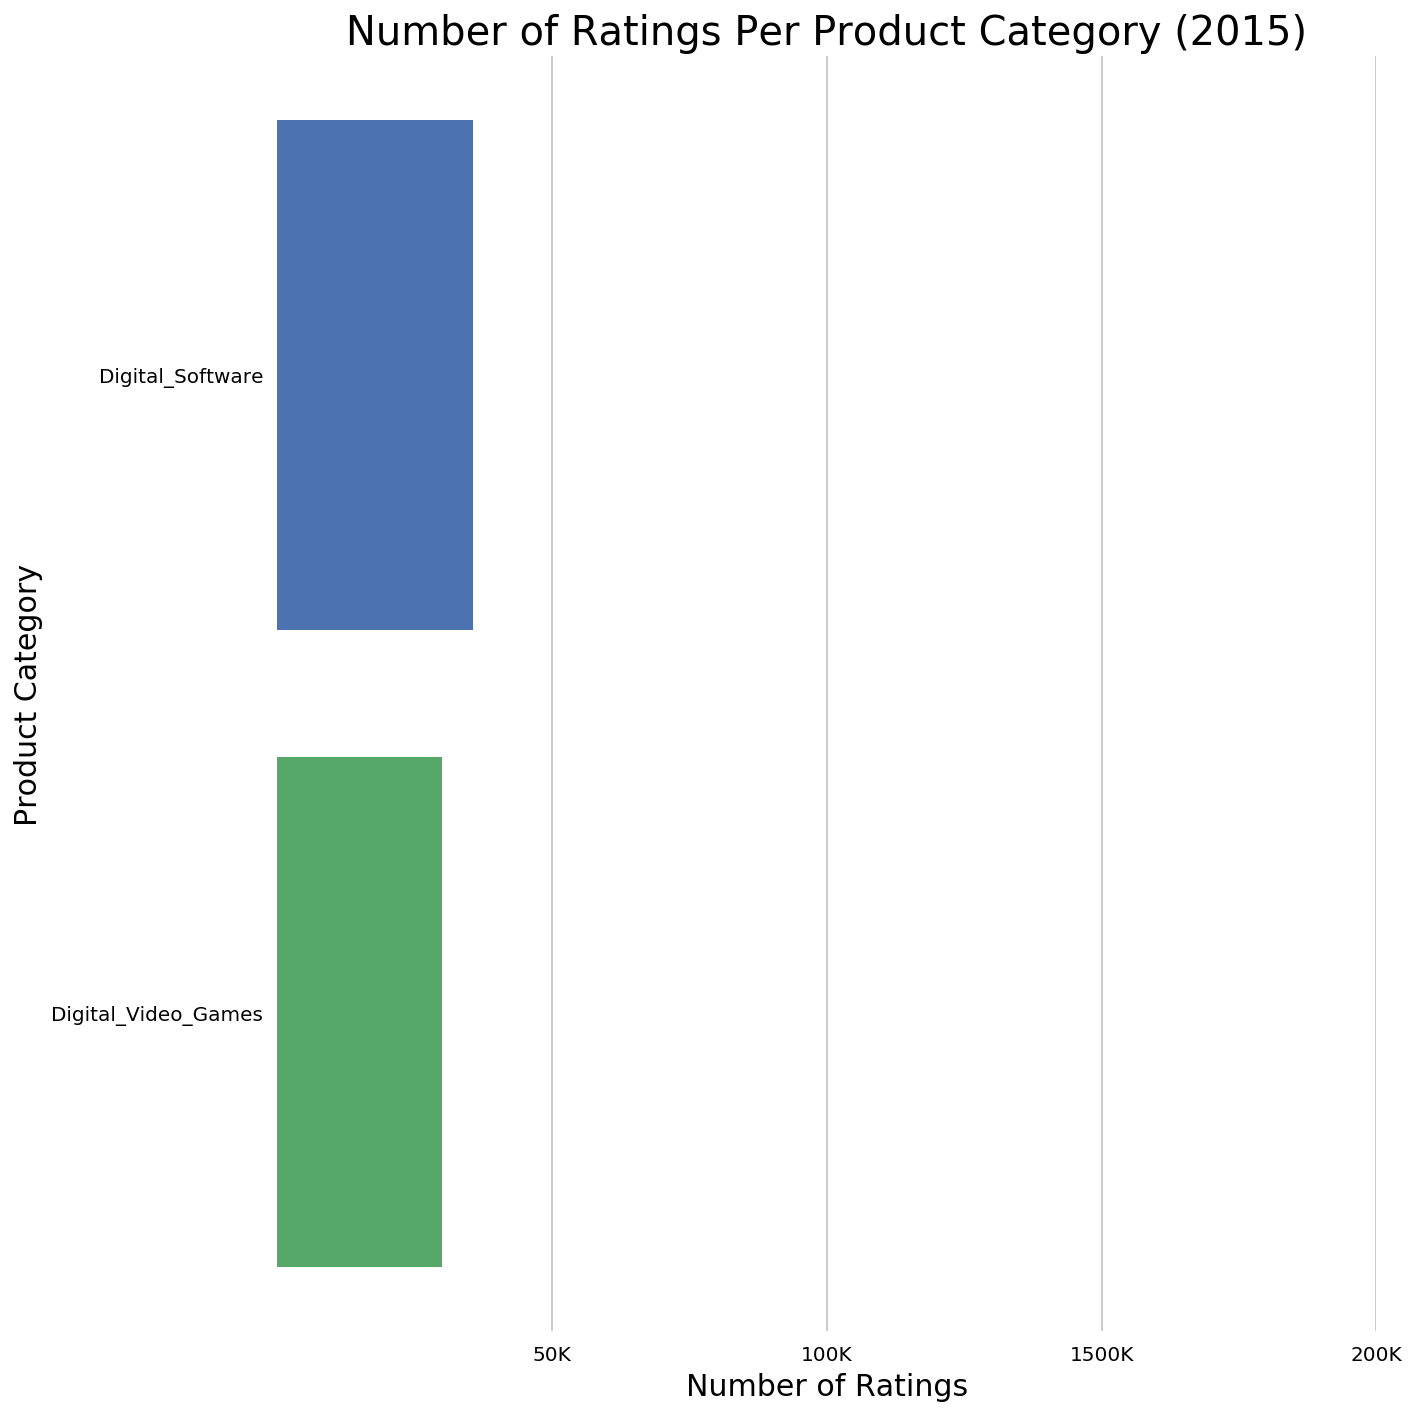

In [13]:
# Create Seaborn barplot
barplot = sns.barplot(y='product_category', x='count_star_rating', data = df, saturation=1)

# Scale if needed
if num_categories < 10:
        sns.set(rc={'figure.figsize':(10.0, 5.0)})
    
# Set title
barplot.set_title("Number of Ratings Per Product Category (2015)", fontsize="20")

# Set x-axis ticks to match scale 
if max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ['50K', '100K', '1500K', '200K'])
    plt.xlim(0, 200000)
elif max_ratings <= 5000000:
    plt.xticks([1000000, 2000000, 3000000, 4000000, 5000000], ['1m', '2m', '3m', '4m', '5m'])
    plt.xlim(0, 5000000)
else:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ['100K', '1m', '5m', '10m','15m','20m'])
    plt.xlim(0, 20000000)

plt.xlabel("Number of Ratings", fontsize="15")
plt.ylabel("Product Category", fontsize="15")

plt.tight_layout()

# Export plot if needed
# plt.savefig('redshift_2015_ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

## Visualization for All Product Categories (150+ Million Reviews)
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-09.png"  width="80%" align="left">

## 2. Which products have the most helpful reviews in 2015?
How long are those reviews?

In [14]:
statement = """
SELECT
    product_title,
    helpful_votes,
    LENGTH(review_body) AS review_body_length,
    SUBSTRING(review_body, 1, 100) AS review_body_substring 
FROM
    {}.{} 
ORDER BY
    helpful_votes DESC LIMIT 10 
""".format(redshift_schema, redshift_table_2015)

print(statement)


SELECT
    product_title,
    helpful_votes,
    LENGTH(review_body) AS review_body_length,
    SUBSTRING(review_body, 1, 100) AS review_body_substring 
FROM
    redshift.amazon_reviews_tsv_2015 
ORDER BY
    helpful_votes DESC LIMIT 10 



In [15]:
df = pd.read_sql_query(statement, engine)

In [16]:
df

,product_title,helpful_votes,review_body_length,review_body_substring
0,Pc Matic Performance Utility Suite (5 User Edi...,484,1478,"I am now a believer, My computer had so many v..."
1,Playstation Network Card,371,94,When i went to the playstation store to redeem...
2,TurboTax Home & Business Fed + E-File + State,328,2063,"Unfortunately, my review is similar to many ot..."
3,RuneScape [Game Connect],299,4,Nice
4,Quicken Deluxe Personal Finance & Budgeting So...,295,9023,I miss Microsoft Money...........This is the n...
5,Adobe Creative Cloud Photography plan (Photosh...,277,986,These are 2 great products and the idea of a s...
6,Block Financial H&R Block Tax Software 14 Prem...,226,3131,This is my first year with H&R Block Tax Softw...
7,Lightroom 6,206,1001,The standalone version is not the newest versi...
8,TurboTax Deluxe Fed + Efile + State,168,2590,For those of you who need schedule D within th...
9,Pc Matic Performance Utility Suite (5 User Edi...,159,925,I bought the 5 user license from Amazon. I lik...


## Results for All Product Categories (150+ Million Reviews)
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/most_helpful_2015.png"  width="90%" align="left">

## 3. What is the breakdown of star ratings (1-5) per product category in 2015?

In [17]:
statement = """
SELECT
    product_category,
    star_rating,
    COUNT(DISTINCT review_id) AS count_reviews 
FROM
    {}.{} 
GROUP BY
    product_category,
    star_rating 
ORDER BY
    product_category ASC,
    star_rating DESC,
    count_reviews
""".format(redshift_schema, redshift_table_2015)

print(statement)


SELECT
    product_category,
    star_rating,
    COUNT(DISTINCT review_id) AS count_reviews 
FROM
    redshift.amazon_reviews_tsv_2015 
GROUP BY
    product_category,
    star_rating 
ORDER BY
    product_category ASC,
    star_rating DESC,
    count_reviews



In [18]:
df = pd.read_sql_query(statement, engine)

In [19]:
df

,product_category,star_rating,count_reviews
0,Digital_Software,5,14864
1,Digital_Software,4,5420
2,Digital_Software,3,3050
3,Digital_Software,2,2537
4,Digital_Software,1,9714
5,Digital_Video_Games,5,19113
6,Digital_Video_Games,4,3185
7,Digital_Video_Games,3,1863
8,Digital_Video_Games,2,1159
9,Digital_Video_Games,1,4706


#### Which product categories are the highest rated by average rating?

In [20]:
# SQL statement
statement = """
SELECT
    product_category,
    COUNT(star_rating) AS count_stars,
    AVG(star_rating::FLOAT) AS avg_star_rating
FROM
    {}.{}  
GROUP BY
    product_category  
ORDER BY
    avg_star_rating DESC
""".format(redshift_schema, redshift_table_2015)

print(statement)


SELECT
    product_category,
    COUNT(star_rating) AS count_stars,
    AVG(star_rating::FLOAT) AS avg_star_rating
FROM
    redshift.amazon_reviews_tsv_2015  
GROUP BY
    product_category  
ORDER BY
    avg_star_rating DESC



In [21]:
df_average_rating = pd.read_sql_query(statement, engine)

In [22]:
df_average_rating

,product_category,count_stars,avg_star_rating
0,Digital_Video_Games,30026,4.027110
1,Digital_Software,35585,3.370465


### Stacked percentage horizontal bar plot showing proportion of star ratings per product category

In [23]:
# Create grouped DataFrames by category and by star rating
grouped_category = df.groupby('product_category')
grouped_star = df.groupby('star_rating')

# Create sum of ratings per star rating
df_sum = df.groupby(['star_rating']).sum()

# Calculate total number of star ratings
total = df_sum['count_reviews'].sum()
print(total)

65611


In [24]:
# Create dictionary of product categories and array of star rating distribution per category
distribution = {}
count_reviews_per_star = []
i=0
    
for category, ratings in grouped_category:
    count_reviews_per_star = []
    for star in ratings['star_rating']:
        count_reviews_per_star.append(ratings.get_value(i, 'count_reviews'))
        i=i+1;
    distribution[category] = count_reviews_per_star

# Check if distribution has been created succesfully
print(distribution)

{'Digital_Software': [14864, 5420, 3050, 2537, 9714], 'Digital_Video_Games': [19113, 3185, 1863, 1159, 4706]}


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [25]:
# Check if distribution keys are set correctly to product categories
print(distribution.keys())

dict_keys(['Digital_Software', 'Digital_Video_Games'])


In [26]:
# Check if star rating distributions are set correctly
print(distribution.items())

dict_items([('Digital_Software', [14864, 5420, 3050, 2537, 9714]), ('Digital_Video_Games', [19113, 3185, 1863, 1159, 4706])])


### Build array per star across all categories

In [27]:
# Sort distribution by highest average rating per category
sorted_distribution = {}

df_average_rating.iloc[:,0]
for index, value in df_average_rating.iloc[:,0].items():
    sorted_distribution[value] = distribution[value]

sorted_distribution

{'Digital_Video_Games': [19113, 3185, 1863, 1159, 4706],
 'Digital_Software': [14864, 5420, 3050, 2537, 9714]}

In [28]:
# Build array per star across all categories
star1 = []
star2 = []
star3 = []
star4 = []
star5 = []

for k in sorted_distribution.keys():
    stars = sorted_distribution.get(k)
    star5.append(stars[0])
    star4.append(stars[1])
    star3.append(stars[2])
    star2.append(stars[3])
    star1.append(stars[4])

## Visualization

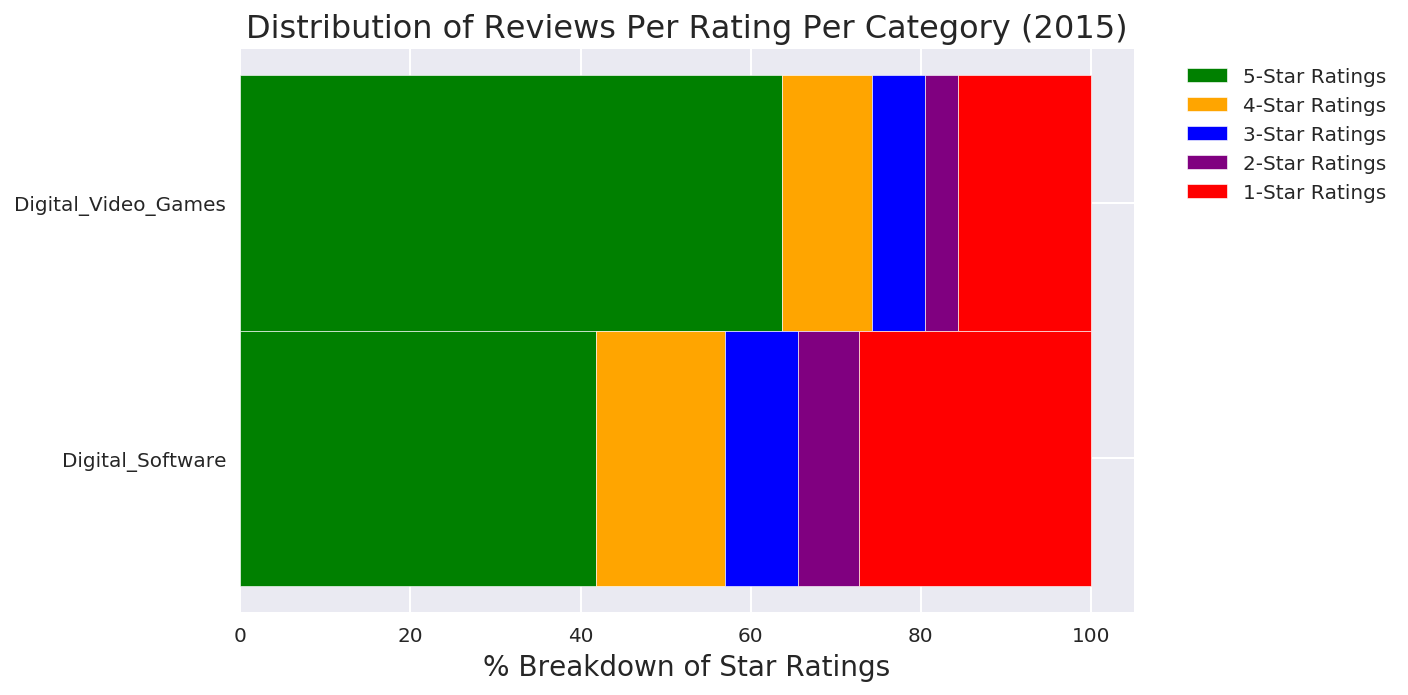

In [29]:
categories = sorted_distribution.keys()

total = np.array(star1) + np.array(star2) + np.array(star3) + np.array(star4) + np.array(star5)

proportion_star1 = np.true_divide(star1, total) * 100
proportion_star2 = np.true_divide(star2, total) * 100
proportion_star3 = np.true_divide(star3, total) * 100
proportion_star4 = np.true_divide(star4, total) * 100
proportion_star5 = np.true_divide(star5, total) * 100

# Add colors
colors = ['red', 'purple','blue','orange','green']

# The position of the bars on the x-axis
r = range(len(categories))
barHeight = 1

# Plot bars
if num_categories > 10:
    plt.figure(figsize=(10,10))
else: 
    plt.figure(figsize=(10,5))

ax5 = plt.barh(r, proportion_star5, color=colors[4], edgecolor='white', height=barHeight, label='5-Star Ratings')
ax4 = plt.barh(r, proportion_star4, left=proportion_star5, color=colors[3], edgecolor='white', height=barHeight, label='4-Star Ratings')
ax3 = plt.barh(r, proportion_star3, left=proportion_star5+proportion_star4, color=colors[2], edgecolor='white', height=barHeight, label='3-Star Ratings')
ax2 = plt.barh(r, proportion_star2, left=proportion_star5+proportion_star4+proportion_star3, color=colors[1], edgecolor='white', height=barHeight, label='2-Star Ratings')
ax1 = plt.barh(r, proportion_star1, left=proportion_star5+proportion_star4+proportion_star3+proportion_star2, color=colors[0], edgecolor='white', height=barHeight, label="1-Star Ratings")

plt.title("Distribution of Reviews Per Rating Per Category (2015)",fontsize='16')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.yticks(r, categories, fontweight='regular')

plt.xlabel("% Breakdown of Star Ratings", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

# plt.savefig('redshift_2015_proportion_star_per_category.png', dpi=300)
plt.show()

## Visualization for All Product Categories (150+ Million Reviews)
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-10.png"  width="70%" align="left">

## 4. How did the star ratings change during 2015?
Is there a drop-off point for certain product categories throughout the year?

In [30]:
statement = """
SELECT
    CAST(DATE_PART('month', TO_DATE(review_date, 'YYYY-MM-DD')) AS INTEGER) AS month,
    AVG(star_rating::FLOAT) AS avg_rating  
FROM
    {}.{} 
GROUP BY
    month
ORDER BY
    month
""".format(redshift_schema, redshift_table_2015)

print(statement)


SELECT
    CAST(DATE_PART('month', TO_DATE(review_date, 'YYYY-MM-DD')) AS INTEGER) AS month,
    AVG(star_rating::FLOAT) AS avg_rating  
FROM
    redshift.amazon_reviews_tsv_2015 
GROUP BY
    month
ORDER BY
    month



In [31]:
df = pd.read_sql_query(statement, engine)
df

,month,avg_rating
0,1,3.486805
1,2,3.587854
2,3,3.762452
3,4,3.634179
4,5,3.691740
5,6,3.740393
6,7,3.808348
7,8,3.773428


## Visualization

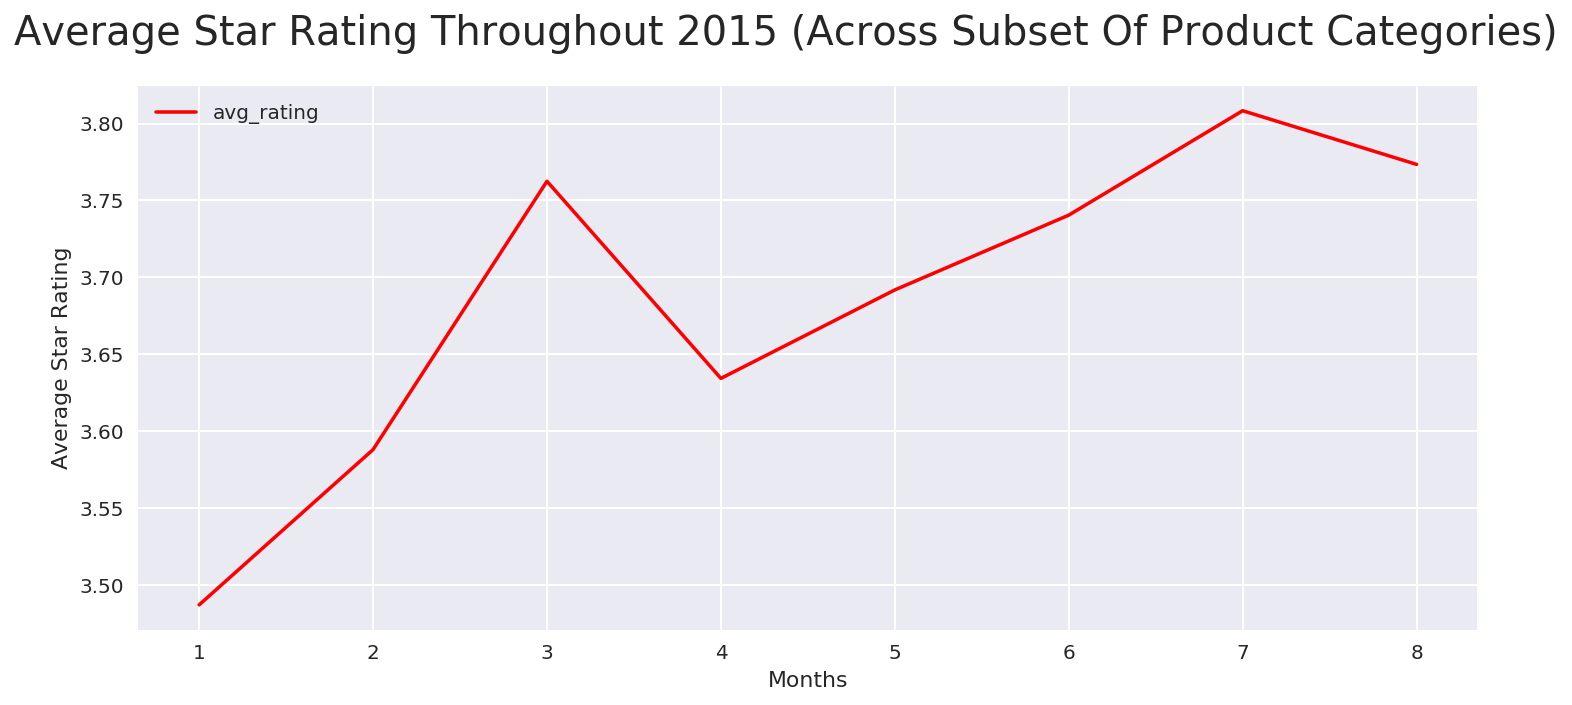

In [32]:
fig = plt.gcf()
fig.set_size_inches(12,5)

fig.suptitle('Average Star Rating Throughout 2015 (Across Subset Of Product Categories)')

ax = plt.gca()

ax.locator_params(integer=True)
ax.set_xticks(df['month'].unique())

df.plot(kind='line',x='month',y='avg_rating', color='red', ax=ax)

plt.xlabel('Months')
plt.ylabel('Average Star Rating')

# fig.savefig('redshift_2015_average_rating.png', dpi=300)
plt.show()

## Visualization for All Product Categories (150+ Million Reviews)
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-11.png"  width="80%" align="left">

## Is there a drop-off point for certain product categories throughout the year?

In [33]:
statement = """
SELECT
    product_category,
    CAST(DATE_PART('month', TO_DATE(review_date, 'YYYY-MM-DD')) AS INTEGER) AS month,
    AVG(star_rating::FLOAT) AS avg_rating  
FROM
    {}.{} 
GROUP BY
    product_category, month
ORDER BY
    product_category, month
""".format(redshift_schema, redshift_table_2015)

print(statement)


SELECT
    product_category,
    CAST(DATE_PART('month', TO_DATE(review_date, 'YYYY-MM-DD')) AS INTEGER) AS month,
    AVG(star_rating::FLOAT) AS avg_rating  
FROM
    redshift.amazon_reviews_tsv_2015 
GROUP BY
    product_category, month
ORDER BY
    product_category, month



In [34]:
df = pd.read_sql_query(statement, engine)
df

,product_category,month,avg_rating
0,Digital_Software,1,2.980648
1,Digital_Software,2,3.286029
2,Digital_Software,3,3.560715
3,Digital_Software,4,3.419297
4,Digital_Software,5,3.458974
5,Digital_Software,6,3.421596
6,Digital_Software,7,3.458573
7,Digital_Software,8,3.421944
8,Digital_Video_Games,1,4.022139
9,Digital_Video_Games,2,4.020500


In [35]:
def plot_categories(df):
    df_categories = df['product_category'].unique()
    for category in df_categories:
        # print(category)
        df_plot = df.loc[df['product_category'] == category]
        df_plot.plot(kind='line',x='month',y='avg_rating', c=np.random.rand(3,), ax=ax, label=category)
        

## Visualization

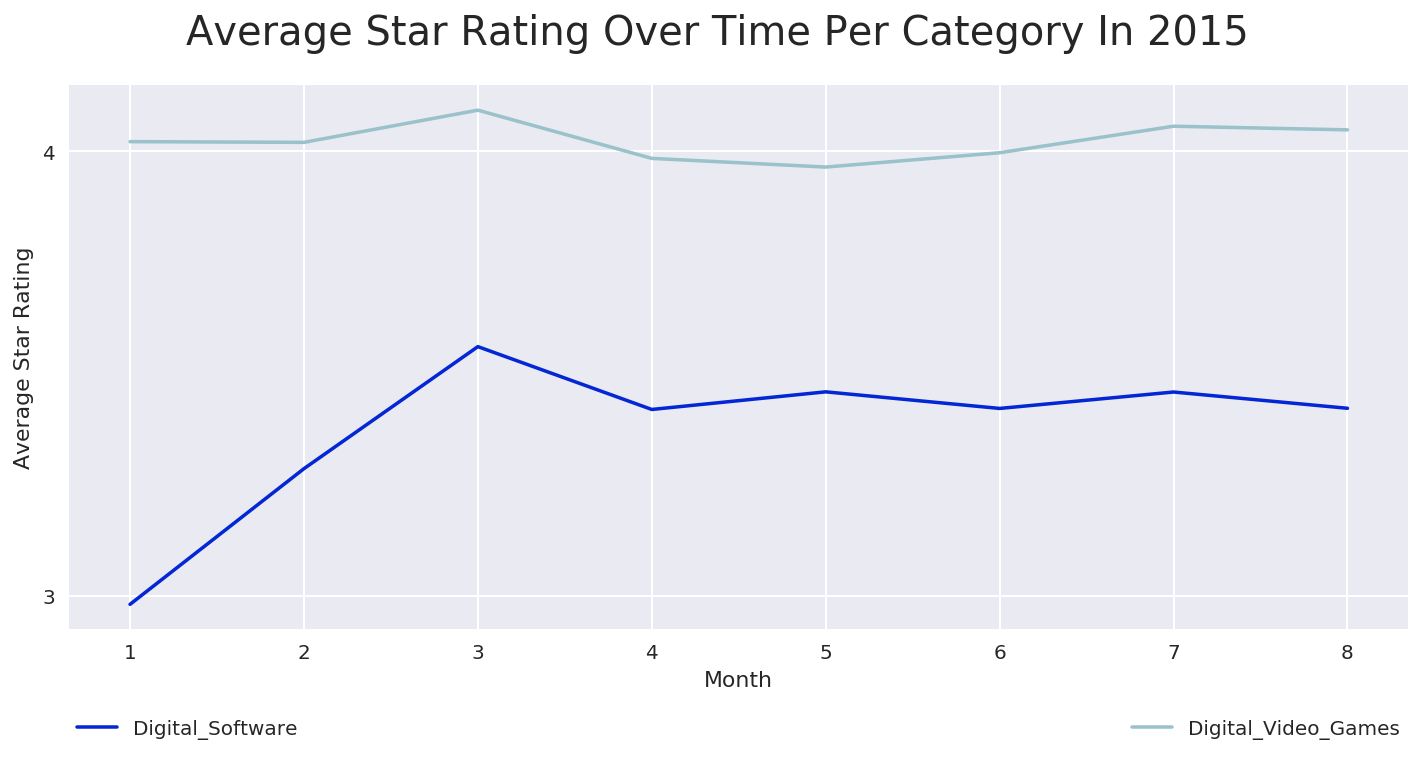

In [36]:
fig = plt.gcf()
fig.set_size_inches(12,5)

fig.suptitle('Average Star Rating Over Time Per Category In 2015')
           
ax = plt.gca()

ax.locator_params(integer=True)
ax.set_xticks(df['month'].unique())

plot_categories(df)

plt.xlabel('Month')
plt.ylabel('Average Star Rating')
plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)

# fig.savefig('redshift_2015_average_rating_category.png', dpi=300)
plt.show()

## Visualization for All Product Categories (150+ Million Reviews)
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

![](img/redshift_2015_average_rating_category.png)

## 5. Which customers are abusing the review system in 2015 by repeatedly reviewing the same product more than once?  
What was their average star rating for each product?


In [37]:
# SQL statement 
statement = """
SELECT
    customer_id,
    product_category,
    product_title,
    ROUND(AVG(star_rating::FLOAT), 4) AS avg_star_rating,
    COUNT(*) AS review_count  
FROM
    redshift.amazon_reviews_tsv_2015 
GROUP BY
    customer_id,
    product_category,
    product_title  
HAVING
    COUNT(*) > 1  
ORDER BY
    review_count DESC LIMIT 5 
""".format(redshift_schema, redshift_table_2015)

print(statement)


SELECT
    customer_id,
    product_category,
    product_title,
    ROUND(AVG(star_rating::FLOAT), 4) AS avg_star_rating,
    COUNT(*) AS review_count  
FROM
    redshift.amazon_reviews_tsv_2015 
GROUP BY
    customer_id,
    product_category,
    product_title  
HAVING
    COUNT(*) > 1  
ORDER BY
    review_count DESC LIMIT 5 



In [38]:
df = pd.read_sql_query(statement, engine)
df

,customer_id,product_category,product_title,avg_star_rating,review_count
0,11421705,Digital_Video_Games,BioWare Points,5.00,8
1,23587418,Digital_Video_Games,BioWare Points,5.00,6
2,4934792,Digital_Video_Games,Grand Theft Auto V Cash Cards,1.00,4
3,5123188,Digital_Video_Games,BioWare Points,5.00,4
4,30754148,Digital_Video_Games,Sims 4,4.25,4


## Visualization for All Product Categories (150+ Million Reviews)
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/redshift-abuse-all.png"  width="80%" align="left">